In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/Kaggle/SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [5]:
df = df.sort_values(['UNIXTime'], ascending = [True])
df['UNIXTime'] = pd.to_datetime(df['UNIXTime'], unit='s')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,2016-09-01 10:00:08,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,2016-09-01 10:05:10,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,2016-09-01 10:20:06,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,2016-09-01 10:25:05,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,2016-09-01 10:30:09,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [6]:
df = df.drop(columns=['Data', 'Time', 'Temperature', 'Pressure', 'Humidity', 
                 'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


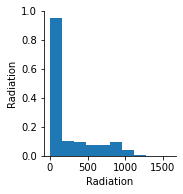

In [7]:
import seaborn as sns
sns.pairplot(df)

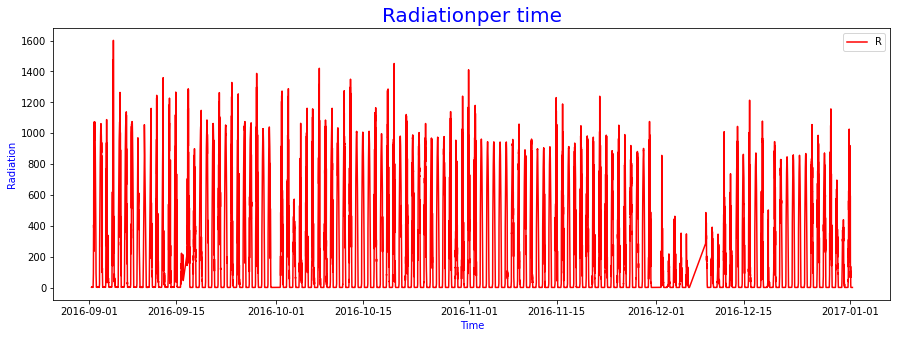

In [8]:
time = df['UNIXTime'].values
radiation  = df['Radiation'].values

plt.figure(figsize=(15,5))
plt.plot(time, radiation, 'r')# 'r' is the color red
plt.title('Radiationper time', fontsize=20,color="blue")

plt.xlabel('Time',color="blue")
plt.ylabel('Radiation',color="blue")

plt.legend('Radiation',loc='upper right')
plt.show()

In [9]:
_, _, _, data_test = train_test_split(time, radiation, test_size=0.2)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(radiation, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(data_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [12]:
range = df['Radiation'].max()-df['Radiation'].min()
range

1600.15

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<range/10 and logs.get('val_mae')<range/10):
      self.model.stop_training = True
callbacks = myCallback()

In [14]:
num_epochs = 30
hist = model.fit(train_set, epochs=num_epochs, validation_data=(test_set), callbacks=[callbacks], verbose=1)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

327/327 [==============================] - 22s 68ms/step - loss: 184.3505 - mae: 184.7496 - val_loss: 215.7686 - val_mae: 216.2537
Epoch 2/30
327/327 [==============================] - 22s 66ms/step - loss: 81.9002 - mae: 82.2756 - val_loss: 210.5079 - val_mae: 210.9929
Epoch 3/30
327/327 [==============================] - 21s 65ms/step - loss: 63.1543 - mae: 63.5215 - val_loss: 200.1172 - val_mae: 200.5995
Epoch 4/30
327/327 [==============================] - 22s 67ms/step - loss: 60.9849 - 

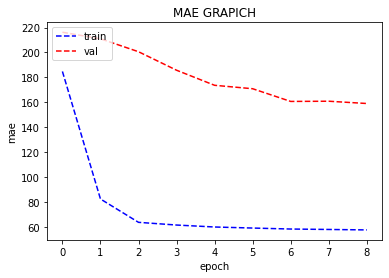

In [20]:
plt.plot(hist.history['mae'], ls='--',color="blue")
plt.plot(hist.history['val_mae'], ls='--',color="red")
plt.title('MAE GRAPICH')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()